## A unified classifiability analysis framework based on meta-learner and its application in spectroscopic profiling data [J]. Applied Intelligence, 2021, doi: 10.1007/s10489-021-02810-8


Propose a framework based on multiple metrics to evaluate the degree of classifibility of data X on category information Y.

## Motivation

In many data-driven discriminative tasks, without specific priori knowledge, scientists often start with popular classifier models in machine learning. If works, bingo! A happy ending. the alorithm can be deployed into production and the researcch get published. Otherwise, continue to try other more sophisticated model. If all major models fail, we have to turn to other detection modalities, which usually mean the modality generating the current data set doesn't capture the information we need for the task.

A fundamental question beneath the above "trial and error" (Trial and error is a fundamental method of problem solving. It is characterised by repeated, varied attempts which are continued until success, or until the practicer stops trying) practice:   
`Does the dataset possess the statistical differences between different groups/classes?` or `Are the samples drawn from different distributions (generation processes)?`

This reveals an implicit and often neglected pre-assessment step in the entire pipeline: the dataset classifiability analysis

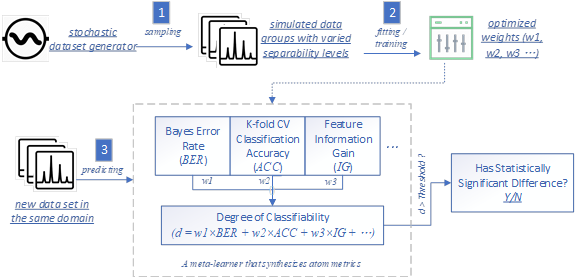

## Metric 1: Bayes Error Rate

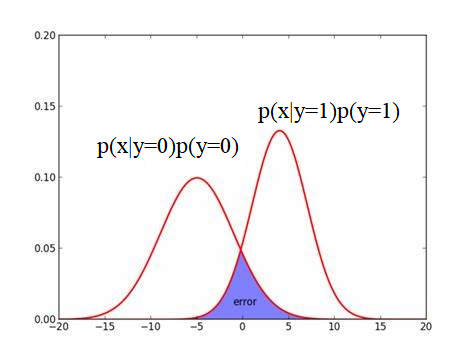

$$ BER= 1- E ({\max}_j P(Y=j|X) $$

It is the lowest possible test error rate in classification which is produced by the Bayes classifier. It is analogous to the irreducible error rate.  

Because of noise (inherently stochastic), the error incurred by the oracle prediction model from the true distribution p(x,y) is the Bayes error.

To calculate BER, we can use the Gaussian Bayes model, based on the naive assumption:   
The features (in this case, PCs returned from PCA in the latent space) conform to Multivariate Gaussian Distributions.  
Each class corresponds to one Gaussian distribution.    

The Bayes optimal decision boundary will correspond to the point where two densities are equal. 


### Why is this Guassian assumption reasonable for spectroscopic data?

According to the central limit theorem (CLT), if a statistic is a sum or average of repetitive measurements, it will be approximately normal under certain technical conditions regardless of the distribution of the individual samples.
Each wave number in Raman or tof in ms, from physical process, is a an accumulation of measurement of photons/ions/particles. 
Features are uncorreleted. In micro level, physical process, photons/ions/particles of different frequency/energy/mass/electric charge don't interfere with each other. 
The coocurrence / correlation between features is a macro relation. i.e., Peak patterns. 

Optional: check feature normality, e.g., by Q-Q plot 


### Implementation

To calculate BER, we can either use: 
1. We need to integrate over the density that is not the highest one for each point. As there are two densities, we need to sum up the two integrals. We can use numerical integration package, e.g. `scipy.integrate`

2. use Gaussian NB classifier, e.g. `sklearn.naive_bayes.GaussianNB`  
`predict_proba()` returns the probability of the samples for each class in the model

## Metric2: Classification Accuracy

Choose SVM (support vector machine) as the base model and use K-fold CV (cross-validation) to pick up the best model.   
CV ensures the classifier has a proper generalization capability (neither underfit or overfit)

## Metric 3: info-gain 

Information gain has been used in decision tree. For a specific feature, Information gain (IG) measures how much “information” a feature gives us about the class.

$IG(Y|X) = H(Y) - H(Y|X) $  

In information theory, IG answers "if we transmit Y, how many bits can be saved if both sender and receiver know X?" Or "how much information of Y is implied in X?"

Attribute/feature X with a high IG is a good split on Y.

### Implementation

It can be proven that `Info Gain = Mutual information`  
We can use `mutual_info_classif` to calculate info gain.      

Be cautious about the `discrete_features` parameter : {‘auto’, bool, array_like}, default ‘auto’

    If bool, then determines whether to consider all features discrete or continuous. If array, then it should be either a boolean mask with shape (n_features,) or array with indices of discrete features. If ‘auto’, it is assigned to False for dense X and to True for sparse X.  
    
For continous feature, use `discrete_features = False`.


Notes

    The term “discrete features” is used instead of naming them “categorical”, because it describes the essence more accurately. For example, pixel intensities of an image are discrete features (but hardly categorical) and you will get better results if mark them as such. Also note, that treating a continuous variable as discrete and vice versa will usually give incorrect results, so be attentive about that.
    True mutual information can’t be negative. If its estimate turns out to be negative, it is replaced by zero.


## Load Dataset

古井贡酒不同年份拉曼光谱 Raman spectra of Gujing Tribute Liquor of different ages



价格与年份基本正比，以500ml瓶装为例，
5-year 200RMB, 8-year 300RMB, 16-year 600RMB, 26-year 1700RMB

### About Gujing Tribute Liquor

With a long history, Gujing Tribute Liquor with fragrant taste is one of the eight most famous liquors in China. In 196AD, Cao Cao presented the "Jiuyun Spring Liquor" that was produced in his hometown as the royal liquor, as well as its brewing methods to the Emperor Xian of Han Dynasty. During the Wan Li Reign of Ming Dynasty, it was presented to the royal court as a "tribute" all the way until Qing Dynasty, hence the liquor is named "Gujing Tribute Liquor" . On the basis of traditional processes, it has scientific recipes and technological innovations. It features "crystal clear, sweet and mellow like orchid, velvety and lasting after tasting" and brings a unique taste known for its sweetness, aroma and full flavor. It was awarded the gold medal of the national liquor-tasting conference for four times, and won the title of "National Famous Liquor". In March 2003, it was incorporated into the system for protecting original products. In 2005, it became national geographical iconic products, gained wide acclaim and has been popular both at home and abroad. (source: http://english.bozhou.gov.cn/content/33.html)

load dataset from 7344_Y5Y26.csv
X.shape (124, 2089)  y.shape (124,)


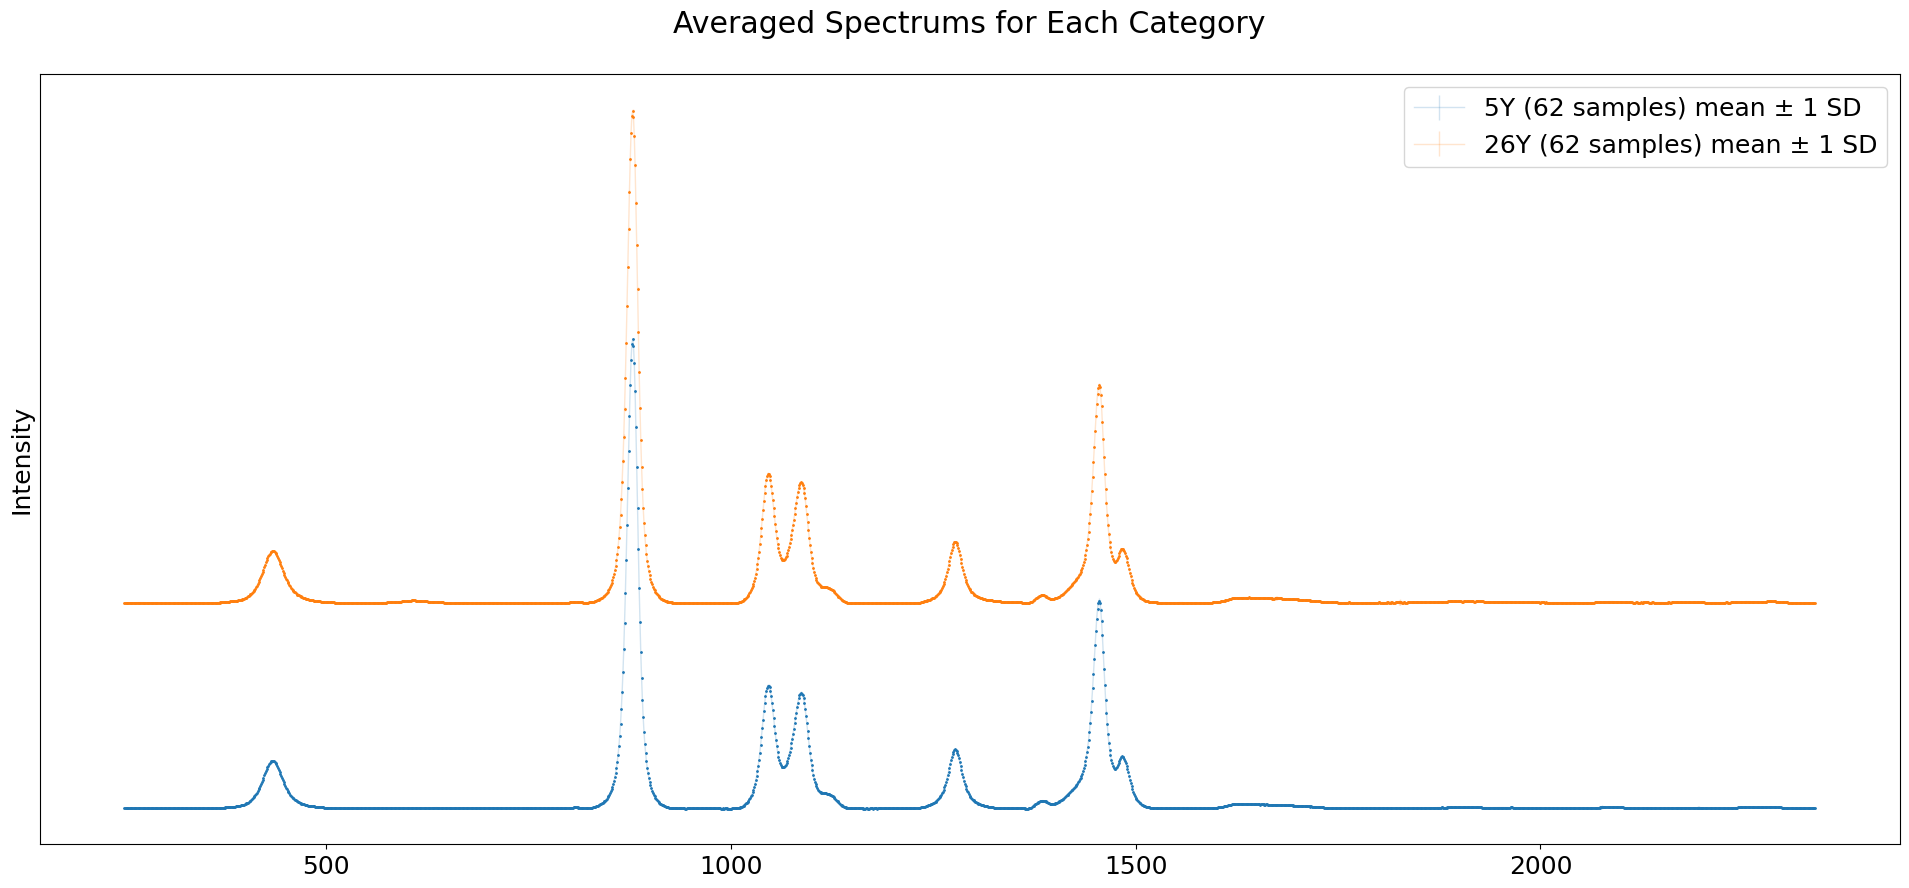

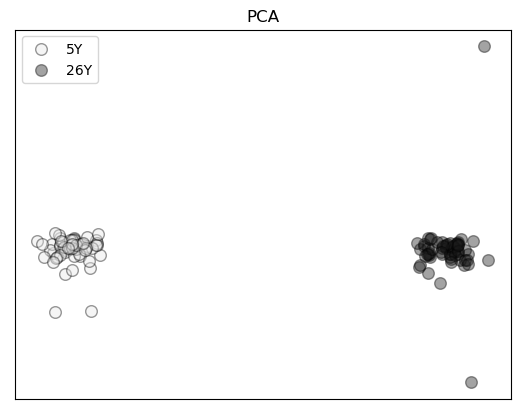

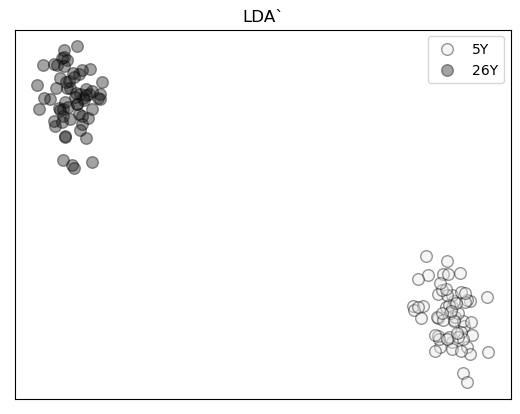

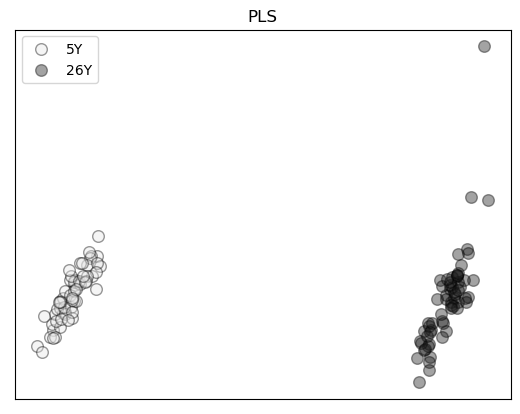

7344_Y5Y26.csv - Raman spectroscopic profiling dataset of 
5-year and 26-year Gujing Tribute vintage liquors. 

y = 0: 5-year
y = 1: 26-year

Each sample has 2088 Raman wavenumbers, ranging from 251 to 2338 cm-1.


In [1]:
from qsi import io
X,y,X_names,_,y_names = io.load_dataset("vintage_526", shift = 3000)

Additional preprocessing steps 

### Feature selection via ElasticNet  

1. Reduce dimension and remove unrelavent features for the classification problem
2. reduce the overfitting risk of successive classification model. Improve the generalization
3. By selecting only a few bunch of features, easier to interpret its chemcial meansings. i.e. gain a better understanding of the features and easy to notice  the co-ocurrance of multiple variables (important for Raman, as one bond or molecule have muliptle peaks).

Highly recommendated for high-dimensional physio-chemical spectroscopic data, e.g., Raman and MALDI-TOF.

### Dimensionality Reduction via PCA

Priori knowledge: The Raman spectrum data only contains additive or linear structures (each chemical bond or particle corresponds to several wave numbers), but no complex embedding structures. So non-linear dimensionality reduction methods, such as kernel PCA, LLE, t-SNE, do not suit. 

### Feature Scaling

Coefficients from LASSO or ElasticNet depend on the magnitude of each variable. It is therefore necessary to rescale, or standardize, the variables.  
The result of centering the variables means that there is no longer an intercept.

Without feature scaling, the feature selection result can be quite different!

# Generate Simulated Datasets

## Dataset 1: mu1 = mu2

In [2]:
import clams

X,y = clams.mvg(
    nobs = 100, # number of observations / samples
    md = 0 # distance between means, respect to std, i.e. (mu2 - mu1) / std, or how many stds is the difference.
    )

Unable to determine R home: [WinError 2] The system cannot find the file specified


rpy2 3.X may not support Windows. ECoL metrics may not be available.


<AxesSubplot:>

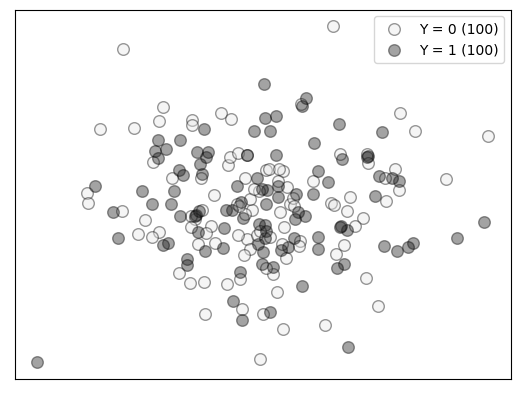

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

from sklearn.decomposition import PCA
X_pca = PCA(n_components = 2).fit_transform(X)
clams.plotComponents2D(X_pca, y)

# Dataset 2: | mu1 - mu2 | = 1 std

<AxesSubplot:>

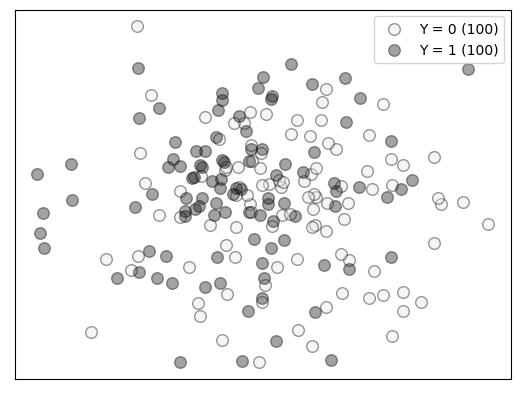

In [4]:
X,y = clams.mvg(
    nobs = 100, # number of observations / samples
    md = 0.5 # distance between means, respect to std, i.e. (mu2 - mu1) / std, or how many stds is the difference.
    )

from sklearn.decomposition import PCA
X_pca = PCA(n_components = 2).fit_transform(X)
clams.plotComponents2D(X_pca, y)

以上分别产生了类间距(md)为0和 0.5 std 的两个数据集。PCA降维后的可视化效果符合预期。

# Metric Implementations

## Metric1: Bayes Error Rate

Use `sklearn.naive_bayes.GaussianNB`  
`predict_proba()` returns the probability of the samples for each class in the model

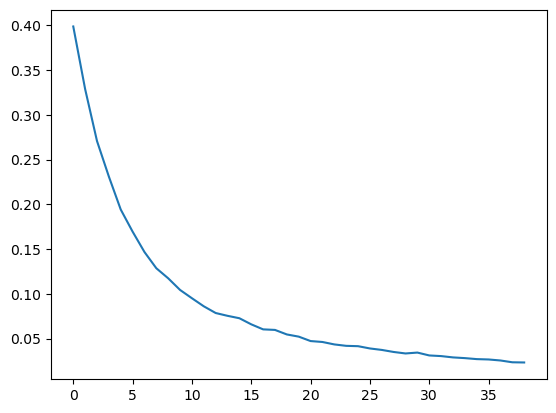

In [5]:
import matplotlib.pyplot as plt

bs = []
for NS in range(1, 40):
    b, _ = clams.BER(X,y, NSigma = NS, save_fig = '')
    bs.append(b)
    
plt.plot(bs)

BER随着采样范围增加而减小，在10sigma 左右达到稳定

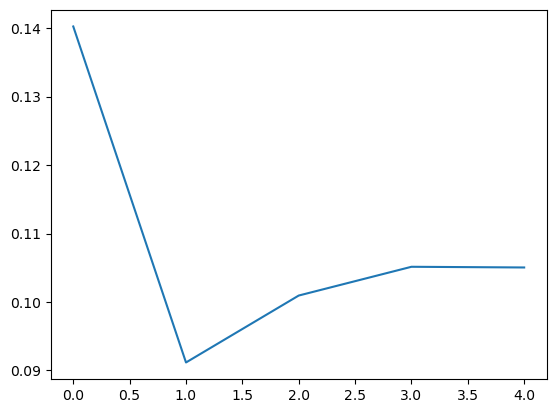

In [6]:
bs = []
for m in [10,100,1000,10000,100000]:
    b,_ = clams.BER(X,y, nobs = int(m), save_fig = '')
    bs.append(b)
    
plt.plot(bs)

BER受随机采样点数影响不大，0.1~0.11范围

## Metric2: Classification Accuracy 

Use cv to get the best classifier. It returns accuracy and decision boundary vertices.  

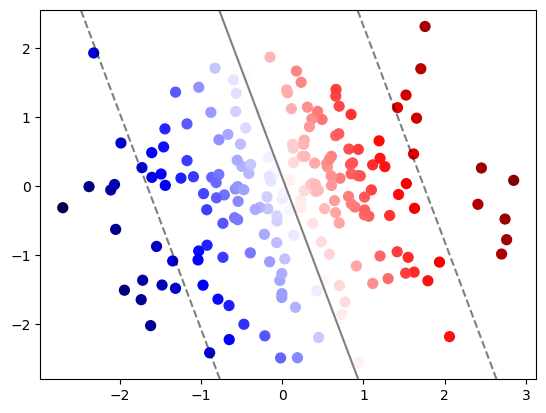

0.615

In [7]:
# NOTE: the CLF in pyCLAMs
dct, *_ = clams.CLF(X,y, show = True)
dct['classification.ACC']

## Info Gain

We prefer Info Gain over Correlation, because:  

Correlation only measures the linear relationship (Pearson's correlation) or monotonic relationship (Spearman's correlation) between two variables.

Mutual information is more general and measures the reduction of uncertainty in Y after observing X. It is the KL distance between the joint density and the product of the individual densities. So MI can measure non-monotonic relationships and other more complicated relationships.

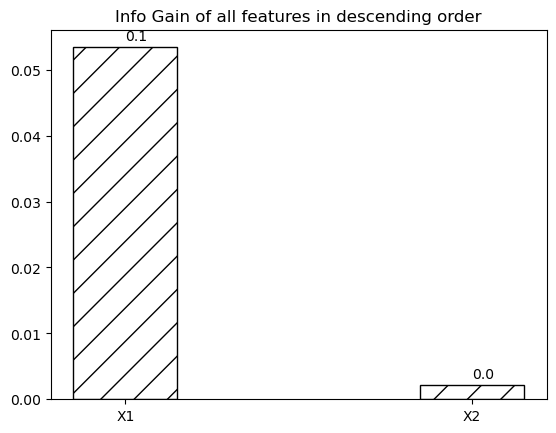

In [8]:
mi,_ = clams.IG(X, y, show = True)

# 3. Define and Train a Unified Metric 

Let's define a unified metric:   
$ D = w_0 + w_1×BER + w_2×ACC + w_3×IG + …  $

We use `mvg()` to generate datasets of different degrees of classifiability. 

## Reload the real dataset 

In [10]:
X,y,X_names,_,y_names = io.load_dataset("vintage_526", display = False)

load dataset from 7344_Y5Y26.csv
X.shape (124, 2089)  y.shape (124,)
7344_Y5Y26.csv - Raman spectroscopic profiling dataset of 
5-year and 26-year Gujing Tribute vintage liquors. 

y = 0: 5-year
y = 1: 26-year

Each sample has 2088 Raman wavenumbers, ranging from 251 to 2338 cm-1.


In [15]:
def mvgx(
    mu, # mean, row vector
    s, # std, row vector
    md = 2, # distance between means, respect to std, i.e. (mu2 - mu1) / std, or how many stds is the difference.
    nobs = 15 # number of observations / samples
    ):
    '''
    Generate simulated high-dim (e.g., spectroscopic profiling) data
    This is an extended version of mvg() that accepts specified mu and s vectors.
    
    Example
    -------
    X,y = mvgx(
    [-1,0,-1], # mean, row vector
    [1,2,0.5], # variance, row vector
    nobs = 5, # number of observations / samples
    md = 1 # distance between means, respect to std, i.e. (mu2 - mu1) / std, or how many stds is the difference.
    )
    '''    
    
    mu = np.array(mu)
    s = np.array(s)
 
    N = nobs
    dims = len(mu)
    cov = np.diag(s**2)
    
    mu1 = mu - s * md / 2
    mu2 = mu + s * md / 2
    
    xc1 = np.random.multivariate_normal(mu1, cov, N)
    xc2 = np.random.multivariate_normal(mu2, cov, N)
    
    y = np.concatenate((np.zeros(N), np.ones(N))).astype(int)
    X = np.vstack((xc1,xc2))
        
    return X, y

In [24]:
# try different sample sizes (nobs)

from tqdm import tqdm, tqdm_notebook
from sklearn.decomposition import PCA
import numpy as np

def Process(mu, s, splits = 11, repeat = 1, nobs = 100, draw = True):

    dims = len(mu)
    
    mds = []
    bers = []
    accs = []
    igs = []
    # ess = []

    # splits (divide 1 std into how many sections) * repeat     
    
    # pbar = tqdm(total = splits * repeat, position=0, leave=True)
    
    for md in np.linspace(0, 1, splits):
        
        ber_sum = 0
        acc_sum = 0
        ig_sum = np.zeros(dims)
        es_sum = np.zeros(dims)
        
        for i in range(repeat):
            X,y = mvgx(
                mu = mu,
                s = s,
                nobs = nobs, # number of observations / samples
                md = md # distance between means, respect to std, i.e. (mu2 - mu1) / std, or how many stds is the difference.
            )
            
            
            if draw == True and i == 0: # only need do visualization once for each d        
                print('d = ', round(md,3))
                plt.figure()
                X_pca = PCA(n_components = 2).fit_transform(X)
                plotComponents2D(X_pca, y)
                plt.xticks([])
                plt.yticks([])
                plt.show()
            
            # X,y = mvg(md = md, nobs = nobs, dims = dims)  # nobs: default 15 samples/class
            b, _ = clams.BER(X,y, show = False);
            ber_sum += b
            
            dct, *_ = clams.CLF(X,y)
            acc_sum += dct['classification.ACC']
            
            ig,_ = clams.IG(X,y, show = False)
            ig_sum += ig
            # a = np.vstack((a,b))
            # print(ig_sum.shape, ig.shape)
            # es_sum += cohen_d(X,y, show = False)
            
            # pbar.update(1)

        bers.append(ber_sum / repeat)
        accs.append(acc_sum / repeat)
        igs.append(ig_sum / repeat)
        # ess.append(es_sum / repeat)
        mds.append(md)
                
    # pbar.close()
    igs = np.array(igs)
    # ess = np.array(ess)
    
    if (draw):

        fig = plt.figure(figsize=(22, 8))

        ax = fig.add_subplot(321)
        plt.scatter(mds, bers)
        plt.plot(mds, bers)
        plt.title("Bayesian Error Rate")
        # plt.axis('tight') # For high dimensionality, BER concentrates on a small range 

        ax = fig.add_subplot(322)
        plt.scatter(mds, accs)
        plt.plot(mds, accs)
        plt.title("Classification Accuracy")
        plt.axis('tight')

        ax = fig.add_subplot(323)
        plt.scatter(mds, igs.mean(axis = 1))
        plt.plot(mds, igs.mean(axis = 1))
        plt.title("Info Gain (mean)")
        plt.axis('tight')
        
        ax = fig.add_subplot(324)
        plt.scatter(mds, igs.max(axis = 1))
        plt.plot(mds, igs.max(axis = 1))
        plt.title("Info Gain (max)")
        plt.axis('tight')
                
    return mds, bers, accs, igs #, ess

In [25]:
def visualize_results(results):
    
    mds, bers, accs, igs = results
    FIGSIZE = (8, 5)
    
    plt.figure(figsize=FIGSIZE)
    plt.scatter(mds, bers, label = "Bayesian Error Rate")
    plt.plot(mds, bers)
    # plt.title("Bayesian Error Rate")
    # plt.axis('tight') # For high dimensionality, BER concentrates on a small range 
    # plt.ylim([0,0.01])
    plt.legend()
    plt.show()

    plt.figure(figsize=FIGSIZE)
    plt.scatter(mds, accs, label = "Classification Accuracy")
    plt.plot(mds, accs)
    # plt.title("Classification Accuracy")
    plt.axis('tight')
    plt.legend()
    plt.show()

    plt.figure(figsize=FIGSIZE)
    plt.scatter(mds, igs.sum(axis = 1), label = "Info Gain (sum)")
    plt.plot(mds, igs.sum(axis = 1))
    # plt.title("Info Gain (mean)")
    plt.axis('tight')
    plt.legend()
    plt.show()

    plt.figure(figsize=FIGSIZE)
    plt.scatter(mds, igs.max(axis = 1), label = "Info Gain (max)")
    plt.plot(mds, igs.max(axis = 1))
    # plt.title("Info Gain (max)")
    plt.axis('tight')
    plt.legend()
    plt.show()

In [27]:
import warnings
warnings.filterwarnings("ignore")

results = Process(mu = X.mean(axis = 0), s = X.std(axis = 0), repeat = 3, nobs = 1000, draw = False)

 48%|████████████████████████████████████▌                                       | 53/110 [2:52:28<3:05:29, 195.25s/it]


In [28]:
import pickle
import joblib

joblib.dump(results, '20221103.pkl')

['20221103.pkl']

In [29]:
import pickle
import joblib

results = joblib.load('20221103.pkl')

In [30]:
from IPython.core.display import display, HTML

def renderTable(results):

    s = '<table>'
    for result in results:
        s+= '<tr>'
        for item in result:            
            s+= '<td>' + str(round(item,3)) + '</td>' # item[0] is key, item[1] is value           
        s+= '</tr>'
    s += '</table>'
    display(HTML(s))

In [31]:
renderTable(np.array([ results[1], results[2], results[3].sum(axis = 1).tolist() ]).T)

0.009,1.0,8.788
0.007,1.0,10.646
0.007,1.0,15.043
0.005,1.0,25.469
0.004,1.0,41.544
0.004,1.0,63.477
0.003,1.0,90.195
0.003,1.0,120.645
0.002,1.0,154.699
0.002,1.0,192.073
0.002,1.0,232.075


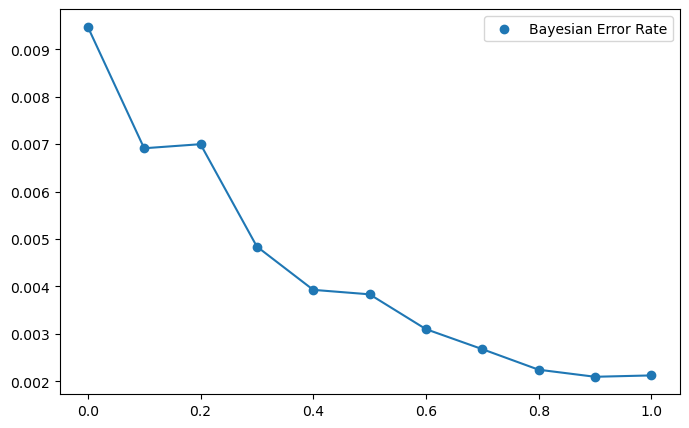

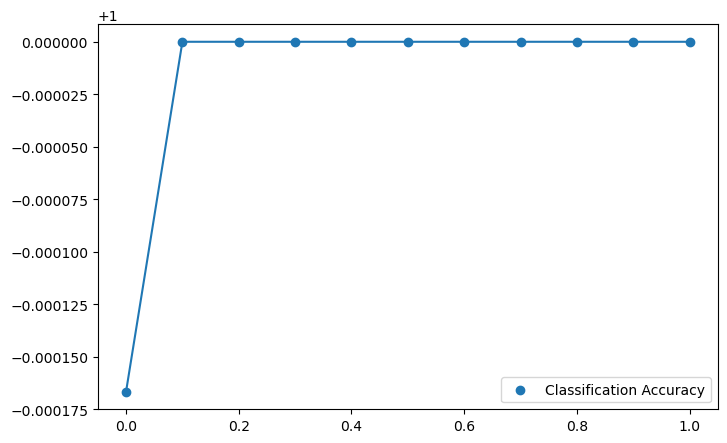

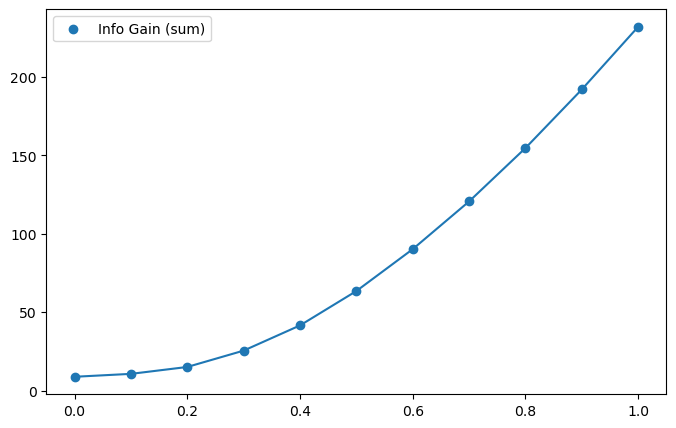

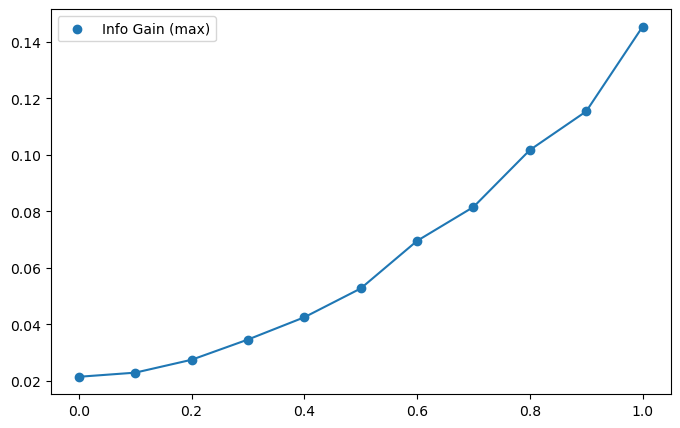

In [32]:
visualize_results(results)

In [33]:
M = np.vstack((np.array(results[:3]), results[3].sum(axis = 1)))

(4.5, -0.5)

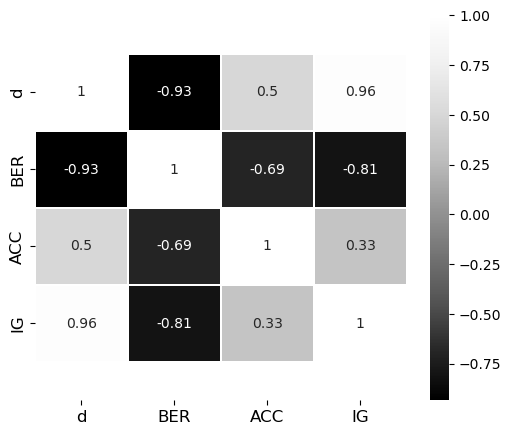

In [34]:
import pandas as pd
import seaborn as sns

plt.figure(figsize = (6,5))
dfM = pd.DataFrame(M.T, columns = ['d', 'BER', 'ACC', 'IG'])

# plot the heatmap
ax = sns.heatmap(dfM.corr(), annot=True, linewidths=.1, cmap = 'Greys_r') # , cbar_kws={"orientation": "horizontal"})
#plt.imshow(MC)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams.update({'font.size': 12})   # restore fontsize

# https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

高维情况下BER的取值偏小（<0.005）。   
ACC收敛过快，大约在0.2就稳定在较高的准确率附近了。其它指标大致呈线性正相关。 

## Learn a regression model

In [35]:
from sklearn.linear_model import LinearRegression

def train_metric_model(results):
    
    d = np.array(results[0])
    
    # Build metric vector
    M = np.vstack((np.array(results[1]), np.array(results[2]), results[3].sum(axis=1))).T
    # print(M.shape, results[3].shape)
    # M = np.hstack((M, results[3]))
    # M = np.hstack((M, results[4]))
    
    reg = LinearRegression().fit(M, d)
    print("Score: ", reg.score(M, d))
    return reg

In [36]:
model = train_metric_model(results) # train the meta-learner model

#plt.figure(figsize=(10,3))
#plt.bar(['BER', "ACC", 'IG'], model.coef_)
model.coef_, model.intercept_

Score:  0.9946945473168273


(array([-6.44560058e+01, -1.42040566e+02,  2.47765716e-03]),
 142.60605550005914)

In [37]:
### This function stacks atom metrics into one long vector 

def amf(X, y):
    M = np.hstack((np.array([clams.BER(X,y)[0], 
                             clams.CLF(X, y)[0]['classification.ACC'],
                             clams.IG(X ,y)[0].sum()])))
    # M = np.hstack((np.array([BER(X,y, show = False), 
    #     CLF(X, y, verbose = False, show = False)]),IG(X ,y, show = False)))
    #M = np.hstack((M, cohen_d(X,y, show = False)))
    return M

# between-class classifiability

In [38]:
from sklearn.decomposition import PCA

def AnalyzeBetweenClass(X,y,model):

    X_pca = PCA(n_components = 2).fit_transform(X)
    clams.plotComponents2D(X_pca, y)        
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    Mb = amf(X,y)
    print("metric = ", model.predict([Mb]))

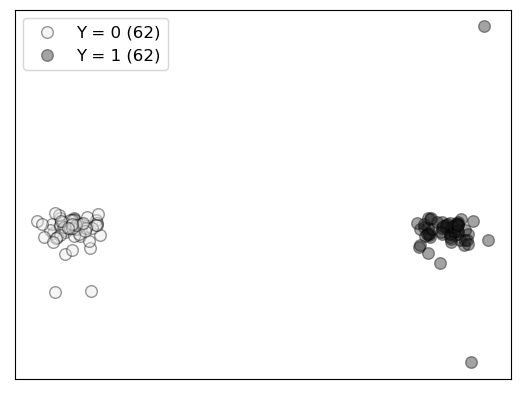

metric =  [1.46908397]


In [39]:
AnalyzeBetweenClass(X,y,model)

# within-class classifiability

In [40]:
def AnalyzeInClass(X, y, model, repeat = 100):

    for c in set(y):    
        
        Xc = X[y == c]
        d = 0
        
        for i in range(repeat):
            yc = (np.random.rand(len(Xc)) > 0.5).astype(int)
            Mc = amf(Xc,yc)
            d += model.predict([Mc])
            
        print("c = ", int(c), ", metric = ", d/repeat)        
        
        X_pca = PCA(n_components = 2).fit_transform(Xc)
        plt.figure()
        clams.plotComponents2D(X_pca, y[y == c])
        plt.xticks([])
        plt.yticks([])
        plt.show()        

c =  0 , metric =  [0.68378796]


<Figure size 640x480 with 0 Axes>

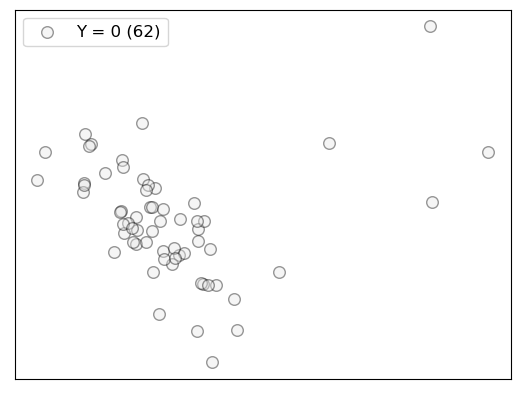

c =  1 , metric =  [0.69332836]


<Figure size 640x480 with 0 Axes>

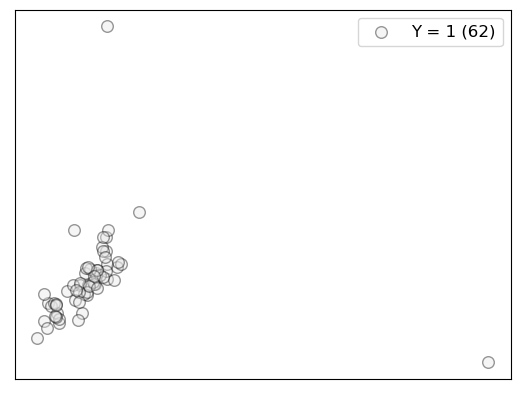

In [41]:
AnalyzeInClass(X, y, model, repeat = 1)

Conclusion: The between-class classifiability metric is much bigger than the in-class value.

# Classfication

Now the above result indicate the dataset is highly classifiable, we train a classifier and measure its performance. 

In [42]:
import clams

# NOTE: the CLF in pyCLAMs
clams.CLF(X,y)

({'classification.ACC': 1.0,
  'classification.Kappa': 1.0,
  'classification.F1_Score': 1.0,
  'classification.Jaccard': 1.0,
  'classification.Precision': 1.0,
  'classification.Recall': 1.0,
  'classification.McNemar': 0.0,
  'classification.McNemar.CHI2': inf,
  'classification.CochranQ': nan,
  'classification.CochranQ.T': nan,
  'classification.CrossEntropy': 0.013733056958972667,
  'classification.Mean_KLD': 0.013733056958972678,
  'classification.AP': 1.0,
  'classification.Brier': 0.00023032462360374553,
  'classification.ROC_AUC': 1.0,
  'classification.PR_AUC': 1.0},
 '',
 'regularization strength\t[0.0001]\n\n\n\nclassification.ACC\t1.0\nclassification.Kappa\t1.0\nclassification.F1_Score\t1.0\nclassification.Jaccard\t1.0\nclassification.Precision\t1.0\nclassification.Recall\t1.0\nclassification.McNemar\t0.0\nclassification.McNemar.CHI2\tinf\nclassification.CochranQ\tnan\nclassification.CochranQ.T\tnan\nclassification.CrossEntropy\t0.013733056958972667\nclassification.Mean_K

# Appendix 

## Raman Spectra Interpretation

<img src='Raman.png'>
<hr/>
<img src='Raman interpretation.jpg'>

Haloalkanes

<pre>
F = Fluoro-
Cl = Chloro-
Br = Bromo-
I = Iodo-

CH3—F 	Fluoromethane 	Methyl fluoride
CH3—Cl 	Chloromethane 	Methyl chloride
CH3—Br 	Bromomethane 	Methyl bromide
CH3—I 	Iodomethane 	Methyliodide 
</pre>

# Appendix

## case study: IRIS dataset

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

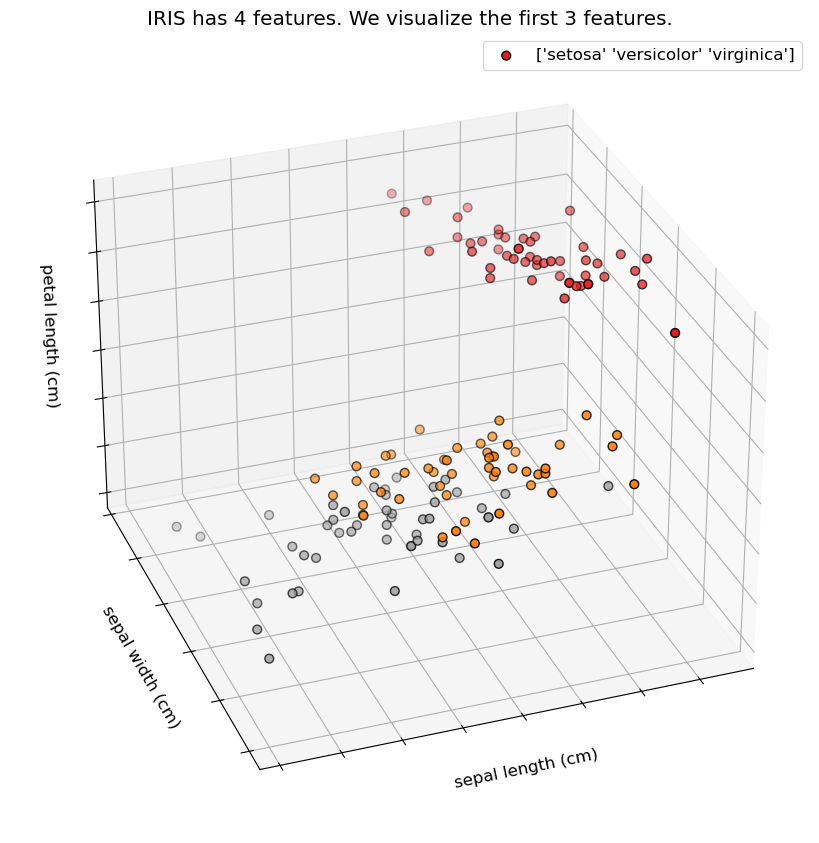

In [44]:
fig = plt.figure(1, figsize=(12, 8))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y,
           cmap=plt.cm.Set1, 
           # edgecolor = ['0.9', '0.1', 'red'],
           edgecolor='k', s=40, label = iris.target_names)
ax.set_xlabel(iris.feature_names[0])
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel(iris.feature_names[1])
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel(iris.feature_names[2])
ax.w_zaxis.set_ticklabels([])

plt.title('IRIS has 4 features. We visualize the first 3 features.')
plt.legend()
plt.show()

visualize after dimRed


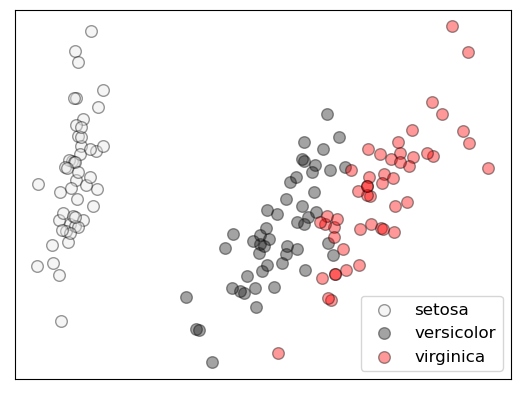

In [45]:
X_pca = PCA(n_components = 2).fit_transform(X)
clams.plotComponents2D(X_pca, y, legends = iris.target_names)
print('visualize after dimRed')

We can see C0 is far from C1 and C2. C1 and C2 are close to each other. 
Next we test their pair-wise scores. 

In [46]:
results_iris = Process(X.mean(axis=0), X.std(axis=0), repeat = 10, nobs = 200, draw = False)

In [47]:
meta_learner = train_metric_model(results_iris)
meta_learner.coef_, meta_learner.intercept_

Score:  0.9987064238425196


(array([2.50348574, 3.34822568, 0.23518714]), -2.036381938378059)

In [49]:
Xcs = []
for c in set(y):
    Xcs.append(X[y==c])
    
import itertools
cmb = list(itertools.combinations(Xcs, 2)) # get all pair-wise combinations
for idx, pair in enumerate(itertools.combinations(set(y), 2)):
    print("\nClasses", pair)    
    Xsubset = np.vstack((cmb[idx][0], cmb[idx][1]))
    ysubset = np.array([0]* len(cmb[idx][0]) + [1]* len(cmb[idx][1]))
    # ysubset = [pair[0]]* len(cmb[idx][0]) + [pair[1]]* len(cmb[idx][1])  # CLF() requires y to be 0 and 1 so that prob metrics can work
    # print(ysubset)
    # AnalyzeBetweenClass(Xsubset, ysubset, meta_learner)
    Mb = amf(Xsubset,ysubset)
    print("metric = ", meta_learner.predict([Mb]))
    
    dct, *_ = clams.CLF(Xsubset,ysubset)
    dct = {key : round(dct[key], 3) for key in dct} # rounding
    print(dct)


Classes (0, 1)
metric =  [1.81953641]
{'classification.ACC': 1.0, 'classification.Kappa': 1.0, 'classification.F1_Score': 1.0, 'classification.Jaccard': 1.0, 'classification.Precision': 1.0, 'classification.Recall': 1.0, 'classification.McNemar': 0.0, 'classification.McNemar.CHI2': inf, 'classification.CochranQ': nan, 'classification.CochranQ.T': nan, 'classification.CrossEntropy': 0.687, 'classification.Mean_KLD': 0.687, 'classification.AP': 1.0, 'classification.Brier': 0.247, 'classification.ROC_AUC': 1.0, 'classification.PR_AUC': 1.0}

Classes (0, 2)
metric =  [1.82208328]
{'classification.ACC': 1.0, 'classification.Kappa': 1.0, 'classification.F1_Score': 1.0, 'classification.Jaccard': 1.0, 'classification.Precision': 1.0, 'classification.Recall': 1.0, 'classification.McNemar': 0.0, 'classification.McNemar.CHI2': inf, 'classification.CochranQ': nan, 'classification.CochranQ.T': nan, 'classification.CrossEntropy': 0.679, 'classification.Mean_KLD': 0.679, 'classification.AP': 1.0, 'c

c =  0 , metric =  [0.11202904]


<Figure size 640x480 with 0 Axes>

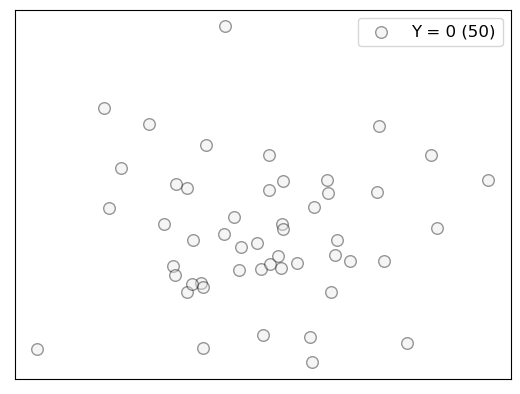

c =  1 , metric =  [0.09066194]


<Figure size 640x480 with 0 Axes>

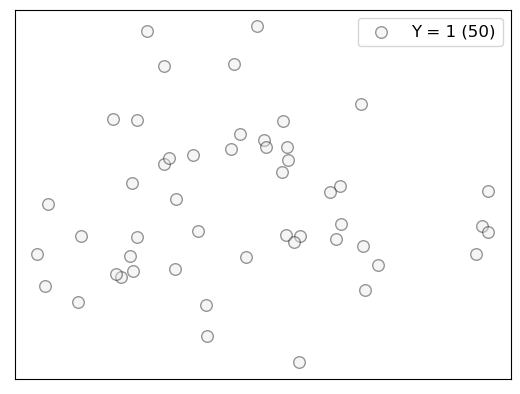

c =  2 , metric =  [0.1086663]


<Figure size 640x480 with 0 Axes>

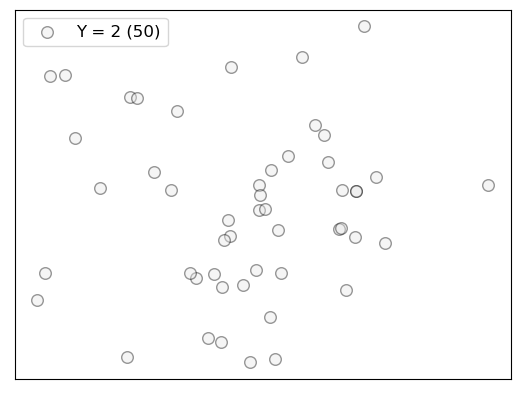

In [50]:
AnalyzeInClass(X,y, meta_learner)

### Data Science Package Version Info

In [51]:
import sklearn
import scipy
import statsmodels
import seaborn
import numpy
import pandas
import qsi
import clams

print(sklearn.__version__, 
      scipy.__version__,
      statsmodels.__version__, 
      seaborn.__version__, 
      numpy.__version__,
      pandas.__version__,
     qsi.__version__,
     clams.__version__)

1.0.2 1.7.3 0.13.2 0.11.2 1.21.5 1.4.2


## TODO

In future, we will integrate all functions in this work to `clams`.